In [15]:
from asyncio.windows_events import NULL
import os
from PIL.Image import ID
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import PlottingFunctions as pf
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

## Plot Trajectory 

In [34]:
def plot_3d_trajectory(pos, boundaries, ID='null'):
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    
    start = 0
    stop = int(len(x)/5)
    stop = np.clip(stop, 10, 10000)
    
    time = np.linspace(start, stop, stop) / stop
    plt.plot(time, x[start:stop], 'b:', label='x')
    plt.plot(time, y[start:stop], 'r:', label='y')
    plt.plot(time, z[start:stop], 'g:', label='z')
    plt.axhline(boundaries[0,0], c='k', label = 'limits')
    plt.axhline(boundaries[0,1], c='k')
    plt.ylim(-3, 3.5)
    plt.grid()
    plt.legend()
    print('Plot 1 of 2')
    plt.savefig(f'Results\\ID{ID}\\3d_trajectory_timeplot.png', format='png')
    plt.show()
    plt.close()

    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(x[:stop], y[:stop], z[:stop], label='path')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    print('Plot 2 of 2')
    plt.show()
    plt.savefig(f'Results\\ID{ID}\\3d_trajectory_spaceplot.png', format='png')
    plt.close()

## Plot Prediction Path

In [39]:
def plot_prediction_path_3d(path, path_in, path_pred, mse_mean, ID=0):
    stop = int(len(path)/5)
    stop = np.clip(stop, 10, 10000)
    # Unpack the actual and predicted coordinates
    x, y, z = path[:, 0], path[:, 1], path[:, 2]
    x_i, y_i, z_i = path_in[:, 0], path_in[:, 1], path_in[:, 2]
    x_pred, y_pred_val, z_pred = path_pred[:, 0], path_pred[:, 1], path_pred[:, 2]

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[:stop], y[:stop], z[:stop], label='Actual path', color='blue')
    ax.plot(x_i[:stop], y_i[:stop], z_i[:stop], 'g:', label='path integrator')
    ax.plot(x_pred[:stop], y_pred_val[:stop], z_pred[:stop], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'First {stop} iterations. Mean MSE = {mse_mean}')

    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID{ID}\\prediction.png', format='png')
    plt.show()
    plt.close()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path)/5)
    stop = np.clip(stop, 10, 10000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='real in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='real in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='real in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID{ID}\\predictionProjected.png', format='png')
    plt.close()

## Plot Neural Activity

In [4]:
def plot_frame_figure(gains, positions_array, network_activity, num_bins=50, neuron=42, ID=0, subID=None):
    """
    Plots a heatmap of network activity at different gain levels and overlays the trajectory. 
    The plot is saved in the results folder within the relative directory.

    :param positions_array: list of shape (ntime, ndim) 
    :param num_bins: int 
    :param network_activity: list of shape (ntime, ngain, nneuron)
    :param neuron: int. Default=42
    """
    x_min, y_min = np.min(positions_array, axis=0)
    x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(13, 8))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
    for a, alpha in enumerate(gains):

        heatmap_ax = fig.add_subplot(gs[0, a])
        heatmap_ax.set_aspect('equal')

        # Initialize an empty heatmap
        x_bins = np.linspace(x_min, x_max,num_bins)
        y_bins = np.linspace(y_min, y_max,num_bins)
        heatmap = np.zeros((num_bins, num_bins))

        # Iterate over positions and network_activity (Over time)
        for position, activity in zip(positions_array, network_activity):
            x_index = np.digitize(position[0], x_bins) - 1
            y_index = np.digitize(position[1], y_bins) - 1
            heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
            #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])
        # add labels left plot
        if a == 0:
            heatmap_ax.set_xlabel('X axis arena')
            heatmap_ax.set_ylabel('Y axis arena')

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID{ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID{ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    plt.show()
    plt.close()

def plot_modular_activity(prj_op, pos, ac, gains, ID):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    for i, p in enumerate(pos2d):
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}')


## Load Data and Prepare

In [21]:
def load_object(filename):
    '''
    load an object from a file using the built-in pickle library

    :param filename: Name of the file from which to load data
    '''
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

In [43]:
name = 'MMC Online'
filename = f'Results\\ID {name}\\Data {name}.pickle'
data = load_object(filename)

online = data['online'] # simulation was online prediction
ID = data['name'] # name of the simulation
boundaries = data['boundaries']
minutes = data['sim time']
dt = data['dt ms'] # in ms
radius = data['radius'] # arena radius
gains = np.array(data['gains']) # list of gains that every network uses
projection = np.array(data['modular projections']) # bool of the dim each module projects
projection_operator = np.array(data['module operators']) # operator used to project 3d data to modules
pos_r = np.array(data['position']) # real position
activity = np.array(data['activity']) # neural network activity 

if online:
    pos_i = np.array(data['position internal']) # integrator position
    pos_p = np.array(data['position prediction']) # predicted position
    mse_ar = np.array(data['predicted mse']) # mse online
else:
    mse_sc = data['mse'] # scalar mse mean offline
    mse_sh = data['mse_shuffeled'] # scalar mse shuffeled offline
    r2 = data['r2_mean'] # scalar r2 score offline
    r2_sh = data['r2_shuffeled'] # scalar r2 shuffeled offline

In [44]:
print(f'''Simulation was run with {'online' if online else 'offline'} prediction.
Name : {ID}
Minutes simulated : {minutes}
Gains used by 2d networks: {gains}
Amount of modules used : {len(projection)}
Projection of the modules by module and dimension : \n{projection}
Timestep dt of the simulation in ms : {dt}
Effective size of the cube : sidelength={2*radius:.2}, Volume={(2*radius)**3:.2}\n''')

print(f"gains shape: {gains.shape}")
print(f"projection_operator shape: {projection_operator.shape}")
print(f"activity shape: {activity.shape}")
print(f"pos_r shape: {pos_r.shape}")

if online:
    print(f"pos_i shape: {pos_i.shape}")
    print(f"pos_p shape: {pos_p.shape}")
    print(f"mse_ar shape: {mse_ar.shape}")
else:
    print(f"mse_sc: {type(mse_sc)}, value: {mse_sc}")
    print(f"mse_sh: {type(mse_sh)}, value: {mse_sh}")
    print(f"r2: {type(r2)}, value: {r2}")
    print(f"r2_sh: {type(r2_sh)}, value: {r2_sh}")

Simulation was run with online prediction.
Name : MMC Online
Minutes simulated : 18.0
Gains used by 2d networks: [0.2 0.4 0.6 0.8 1. ]
Amount of modules used : 2
Projection of the modules by module and dimension : 
[[ True  True False]
 [False  True  True]]
Timestep dt of the simulation in ms : 32
Effective size of the cube : sidelength=8.6, Volume=6.3e+02

gains shape: (5,)
projection_operator shape: (2, 2, 3)
activity shape: (33563, 2, 5, 90)
pos_r shape: (33563, 3)
pos_i shape: (33563, 3)
pos_p shape: (33563, 3)
mse_ar shape: (33563, 3)


In [45]:
print('pos real min, max:', np.min(pos_r), np.max(pos_r))
print('pos internal :', np.min(pos_p), np.max(pos_p))
print('pos predicted :', np.min(pos_i), np.max(pos_i))

pos real min, max: -2.583813599782407 2.7088953671429246
pos internal : -3.0267167763012375 2.8138344961050548
pos predicted : -2.863957235653073 2.2672948900332415


In [46]:
def pos_2d(pos, op=projection_operator):
    return np.einsum('myx, tx->mty', op, pos) # m = module, y = 3d, x = 2d, t = time

pos_r_2d = pos_2d(pos_r)
if online:
    pos_i_2d = pos_2d(pos_i)
    pos_p_2d = pos_2d(pos_p)

In [47]:
np.shape(pos_r_2d)

(2, 33563, 2)

## Produce Plots

Plot 1 of 2


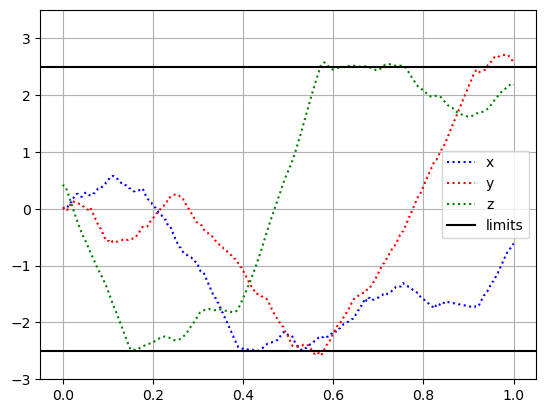

Plot 2 of 2


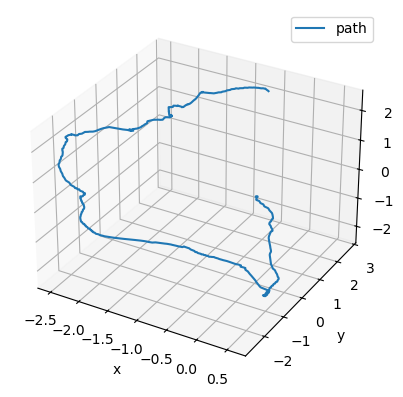

In [48]:
plot_3d_trajectory(pos_r, boundaries, ID=name)

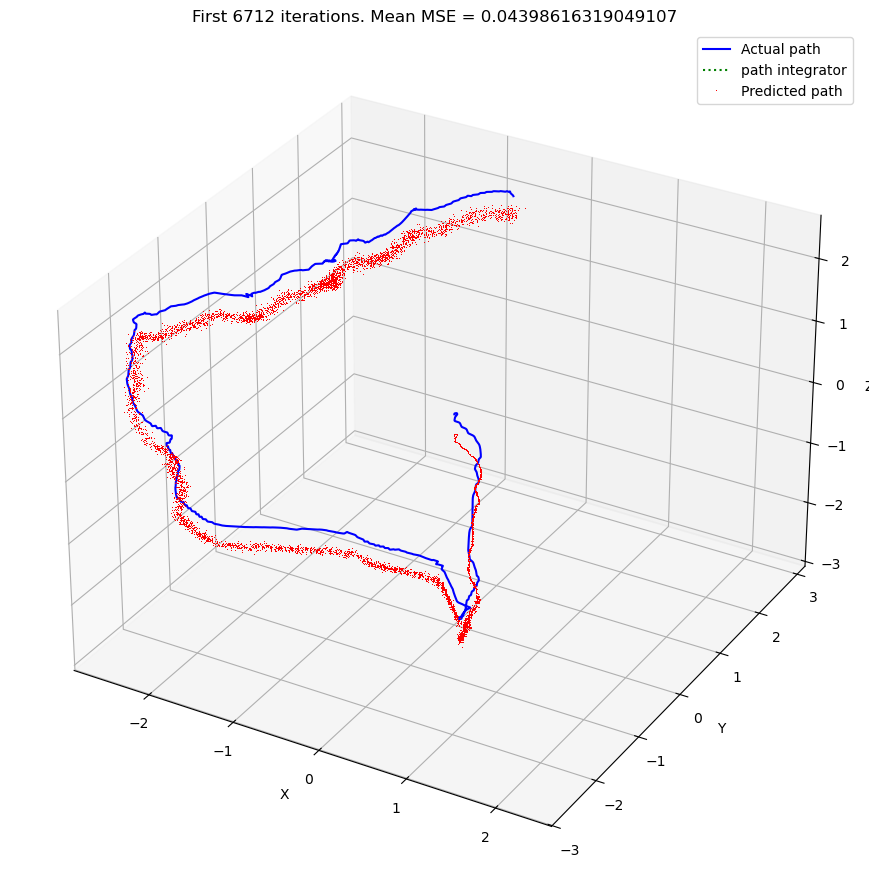

In [49]:
plot_prediction_path_3d(pos_r, pos_i, pos_p, np.mean(mse_ar), ID=ID)

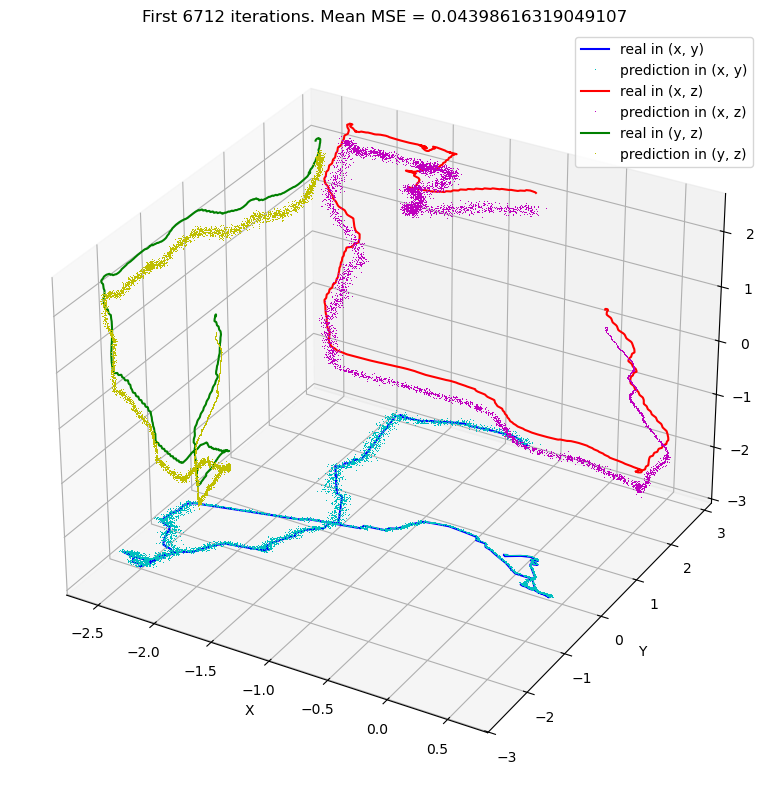

In [50]:
prediction_path_projected(pos_r, pos_p, mse_ar, ID=ID)

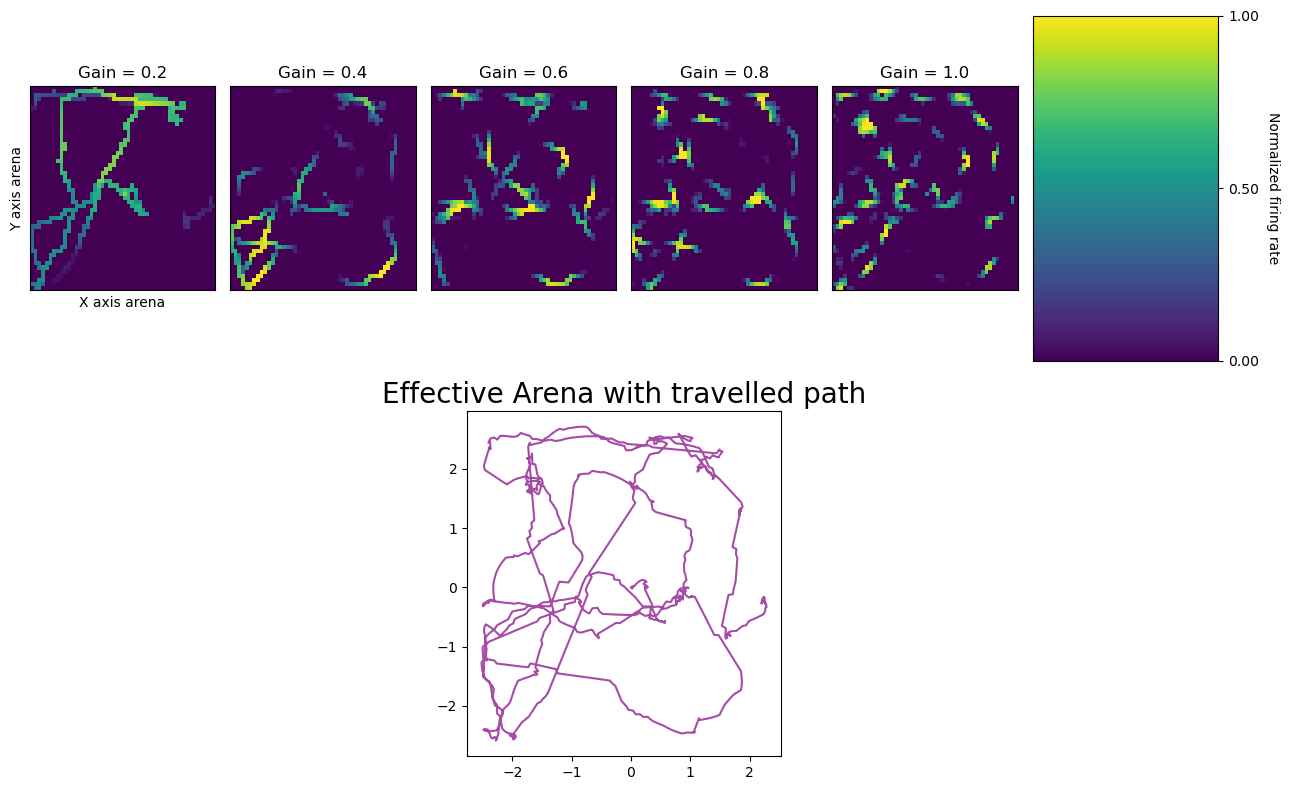

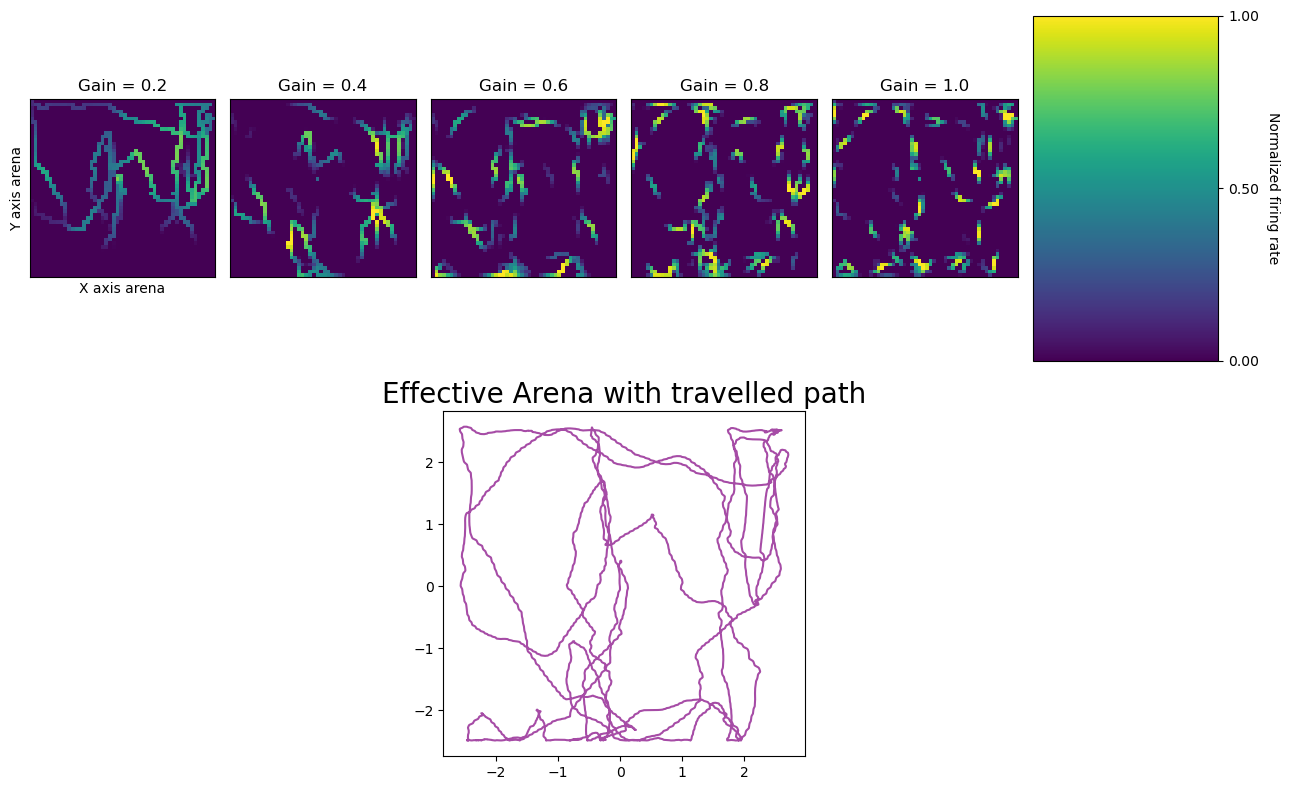

In [51]:
plot_modular_activity(projection_operator, pos_r, activity, gains, ID)